In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#from scipy.stats import describe
#import math
#import os
import glob
import datetime
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
%matplotlib inline
### Separate file with functions
execfile("../src/utils/_plot_and_wrangling_functions.py")


In [6]:
#### Checking all data files available
glob.glob('../data/*')

['../data\\holidays_events.csv',
 '../data\\oil.csv',
 '../data\\sample_submission.csv',
 '../data\\stores.csv',
 '../data\\test.csv',
 '../data\\train.csv',
 '../data\\transactions.csv']

In [7]:
#### Loading all data into dataframes
train_df = pd.read_csv('../data/train.csv')
holidays_df = pd.read_csv('../data/holidays_events.csv')
oil_df = pd.read_csv('../data/oil.csv')
stores_df = pd.read_csv('../data/stores.csv')
transactions_df = pd.read_csv('../data/transactions.csv')
sample_df = pd.read_csv('../data/sample_submission.csv')
test_df = pd.read_csv('../data/test.csv')

##### Understanding Holidays

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

 Source: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [8]:
### We drop every row where the tranferred == True, since the database already provides a new row to when the holiday was transferred to
### A better approach would test if the transferred holidays have any significant impact compared to regular holidays or create
### a column for each holiday with a boolean value if it is that holiday or not
holidays_df2 = holidays_df[holidays_df['transferred'] == False].copy()

In [9]:
holidays_df2.head(3)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   

   transferred  
0        False  
1        False  
2        False

In [10]:
#### Now we group the dataframe to have only the date, locale and locale_name, which will be our keys for future joins
#### Using this approach, we will create a single column in the training dataframe if is holiday or not
#### Another option would be creating a boolean value per holiday so we can also measure different impacts on the sales
holidays_df3 = (holidays_df2.groupby(['date','locale','locale_name'], as_index = False)['description'].count()
                .sort_values(by = ['description'], ascending= [False]))

In [11]:
holidays_df4 = holidays_df3[['date','locale','locale_name']].drop_duplicates() 

In [ ]:
holidays_df4.sort_values(by = 'date').head(5)

date    locale locale_name
0  2012-03-02     Local       Manta
1  2012-04-01  Regional    Cotopaxi
2  2012-04-12     Local      Cuenca
3  2012-04-14     Local    Libertad
4  2012-04-21     Local    Riobamba

In [ ]:
holidays_df4.groupby('locale', as_index = False)['date'].count()

locale  date
0     Local   147
1  National   160
2  Regional    24

In [ ]:
#### Here we can see that we will need to split the holidays to merge them correctly depending
#### on the locale_name
#### We will later explore the relationship of holidays and sales
holidays_df4.groupby('locale_name', as_index = False)['date'].count()

locale_name  date
0                           Ambato    12
1                          Cayambe     6
2                         Cotopaxi     6
3                           Cuenca     6
4                          Ecuador   160
5                        El Carmen     6
6                       Esmeraldas     6
7                         Guaranda    12
8                        Guayaquil     9
9                           Ibarra     6
10                        Imbabura     6
11                       Latacunga    12
12                        Libertad     6
13                            Loja     6
14                         Machala     6
15                           Manta     6
16                            Puyo     6
17                         Quevedo     6
18                           Quito    12
19                        Riobamba    12
20                         Salinas     6
21                     Santa Elena     6
22                   Santo Domingo     6
23  Santo Domingo de los Tsachilas     6

#### Working with oil dataset

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

Since this is a stock information, we need to fill in the days that there is no market trade

In [21]:
print(f'There are {train_df["date"].nunique() + test_df["date"].nunique()} days available in the dataset')
print(f'But there are {(pd.to_datetime(test_df["date"].max()) - pd.to_datetime(train_df["date"].min()))} days between first and last day')

There are 1700 days available in the dataset
But there are 1703 days 00:00:00 days between first and last day


In [22]:
#### We create a dataframe with the first day available in the train_df and with the last day of test_df and set the freq to daily
totaldays = pd.DataFrame({'date': pd.date_range(start = train_df['date'].min(), end = test_df['date'].max())})
totaldays['date'].freq = 'd'

In [23]:
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [24]:
#### Merge the two dataframes and do a backward fill to get the correct values of the day
#### then we transform the column to datetime format. Now we can plot and understand the data
oil_df2 = totaldays.merge(oil_df, how = 'left', on = 'date').bfill()
oil_df2['date'] = pd.to_datetime(oil_df2['date'])

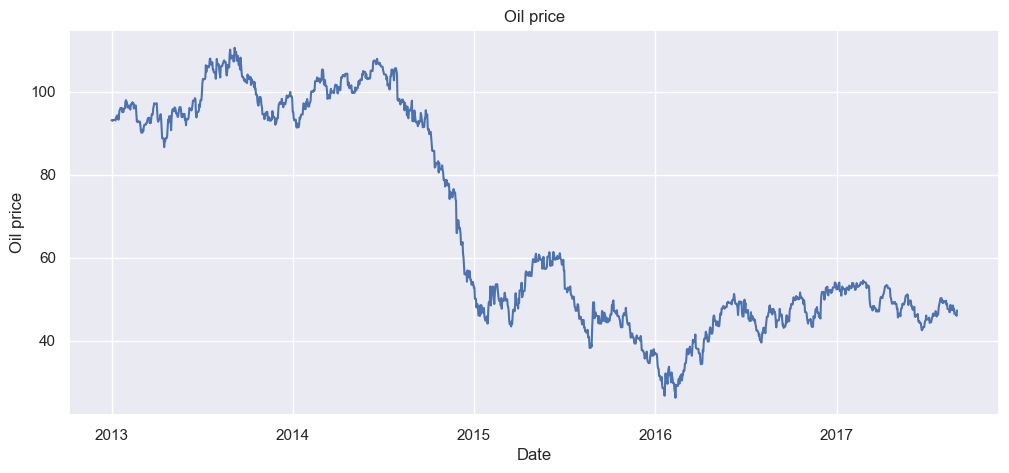

In [25]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(oil_df2, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.show()

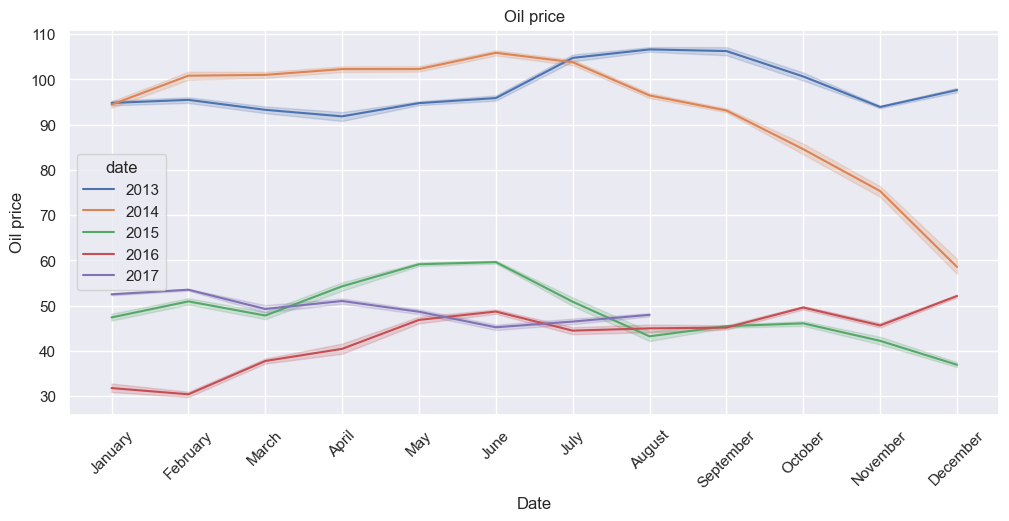

In [26]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(oil_df2, 
              x = oil_df2['date'].dt.strftime('%B'), 
              y = 'dcoilwtico', 
              hue = oil_df2['date'].dt.strftime('%Y'),
              ))
plt.title('Oil price')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.xticks(rotation = 45)
plt.show()

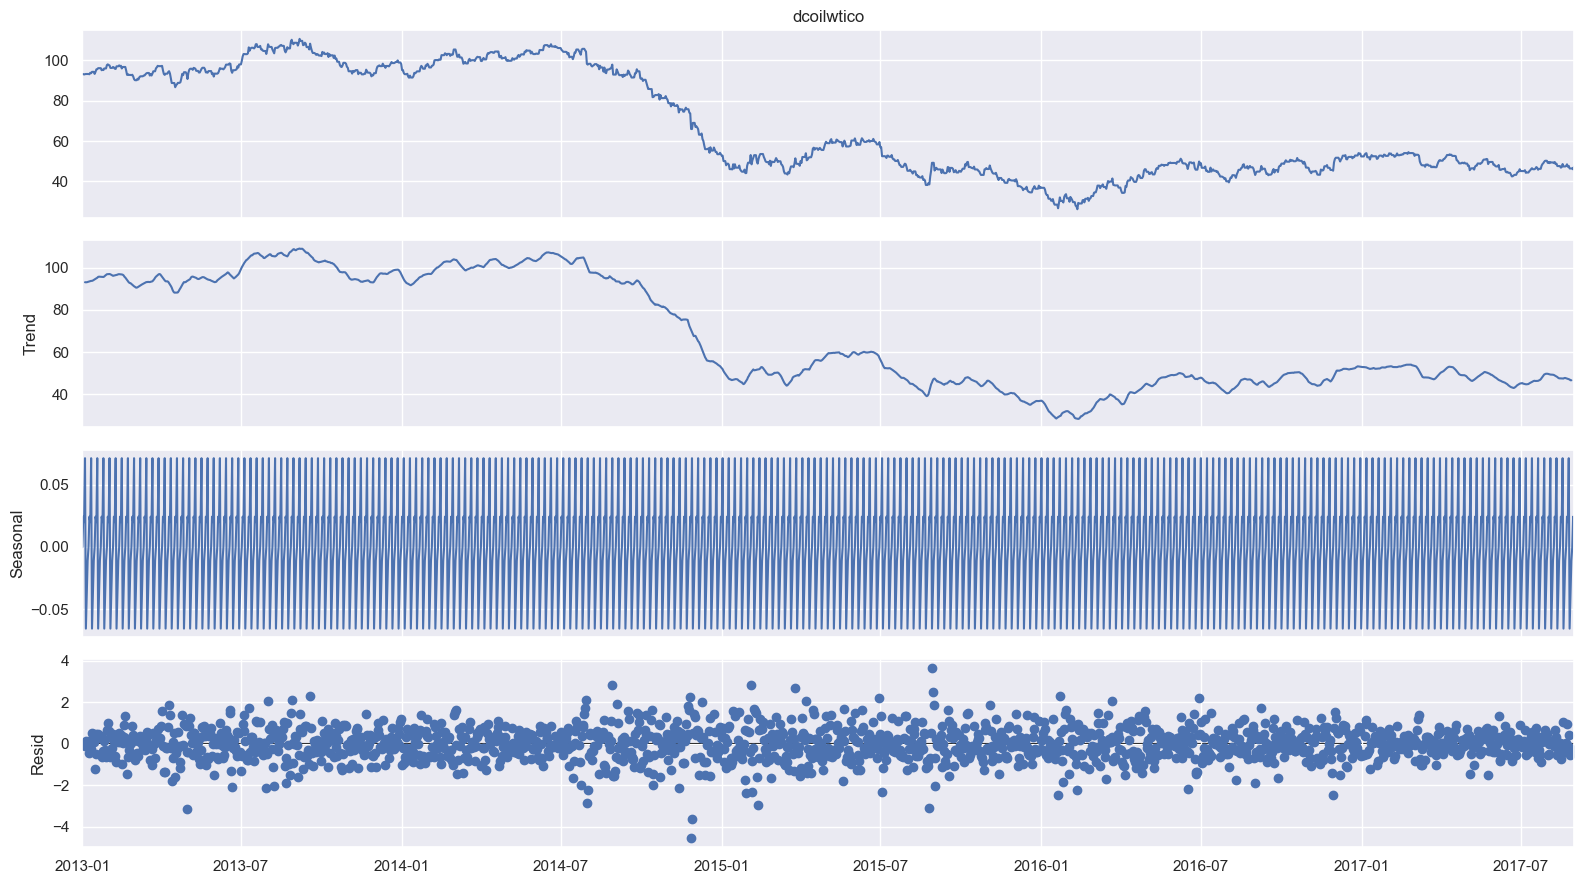

In [27]:
#Test for Seasonality
# Perform seasonal decomposition
oil_df3 = oil_df2.copy()#[oil_df2['date'].between('2013-01-01','2014-01-01')].copy()
oil_df3.set_index('date', inplace = True)
oil_df3.index.freq = 'd'
res = sm.tsa.seasonal_decompose(oil_df3.dcoilwtico)

# Create a larger figure and plot the decomposed components
fig = res.plot()
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

#### Evaluating total sales

In [28]:
sales_df = train_df.copy()
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [29]:
total_sales = sales_df.groupby(['date'], as_index = False)[['sales','onpromotion']].sum()

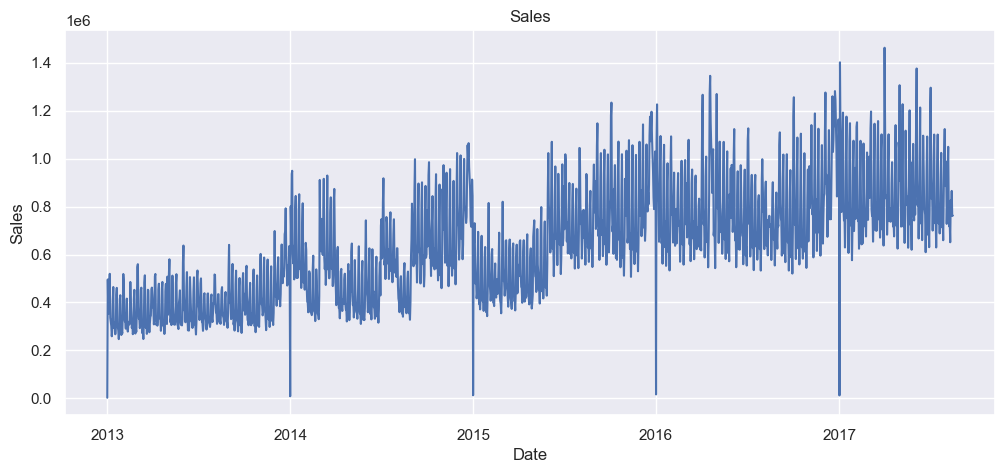

In [30]:
#### We can see there is a oil shock between 2014 and 2015. After that it slowly decreased until it hits the bottom in 2016.
### After that it stayed stable up until the last day of the dataset.
plt.figure(figsize = (12,5))
sns.lineplot(total_sales, x = 'date', y = 'sales')
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

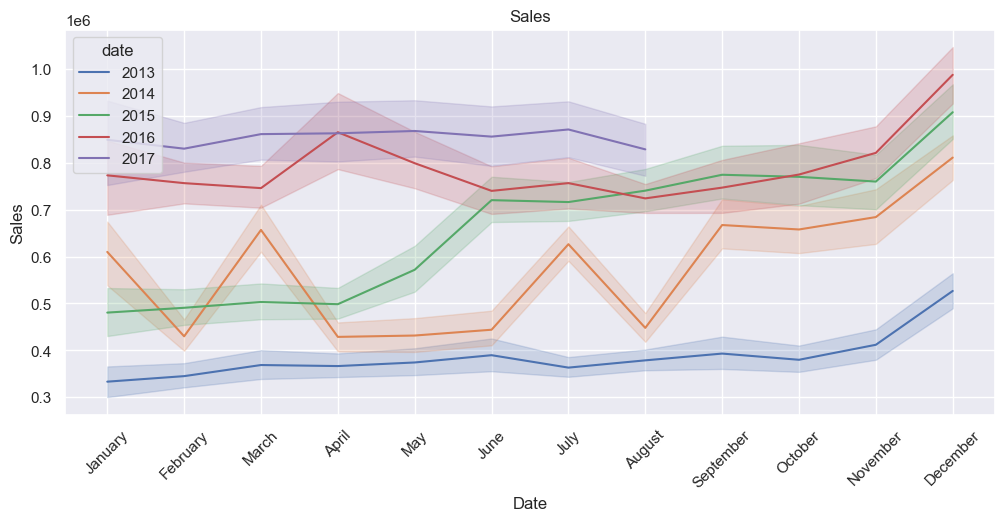

In [31]:
#### We can also check for seasonality between the years. We can't clearly see any monthly pattern, so we use can use a seasonal decompose
#### to evaluate the other seasonalities
plt.figure(figsize = (12,5))
(sns.lineplot(total_sales, 
              x = total_sales['date'].dt.strftime('%B'), 
              y = 'sales', 
              hue = total_sales['date'].dt.strftime('%Y'),
              ))
plt.title('Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

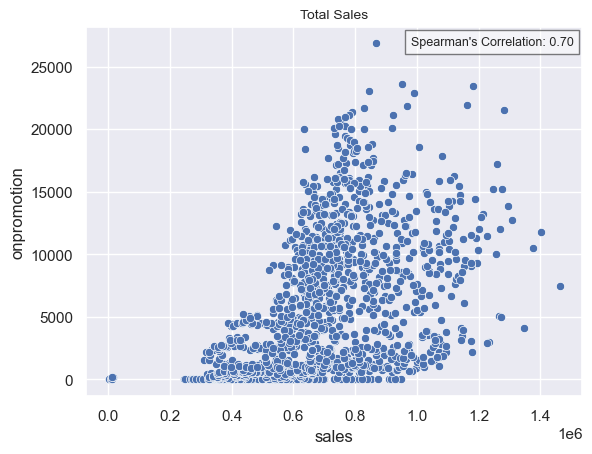

In [32]:
sns.scatterplot(data=total_sales, x='sales', y='onpromotion')

# Spearman correlation
spearman_correlation = total_sales['sales'].corr(total_sales['onpromotion'], method='spearman')
textstr = f"Spearman's Correlation: {spearman_correlation:.2f}"

# Add correlation text

plt.text(
    x=total_sales['sales'].max() * 0.67,
    y=total_sales['onpromotion'].max() * 0.995,
    s=textstr,
    fontsize=9,
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)
plt.title(f"Total Sales", fontsize=10)
plt.show()

In [36]:
### Evaluating stationarity in the series -> It is a non-stationary series. We can differentiate and check again
check_stationarity(total_sales['sales'])

ADF Statistic: -2.616196
p-value: 0.089696
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Non-stationary


In [37]:
total_sales['dif_sales'] = total_sales['sales'].diff()
total_sales['dif_sales'].fillna(0, inplace = True)

In [38]:
### For models that require a stationary series, we can use the differentiation of the series
check_stationarity(total_sales['dif_sales'])

ADF Statistic: -11.495798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


#### Evaluating Sales per product

In [39]:
prd_sales_df = sales_df.groupby(['date','family'], as_index=False)[['sales','onpromotion']].sum()

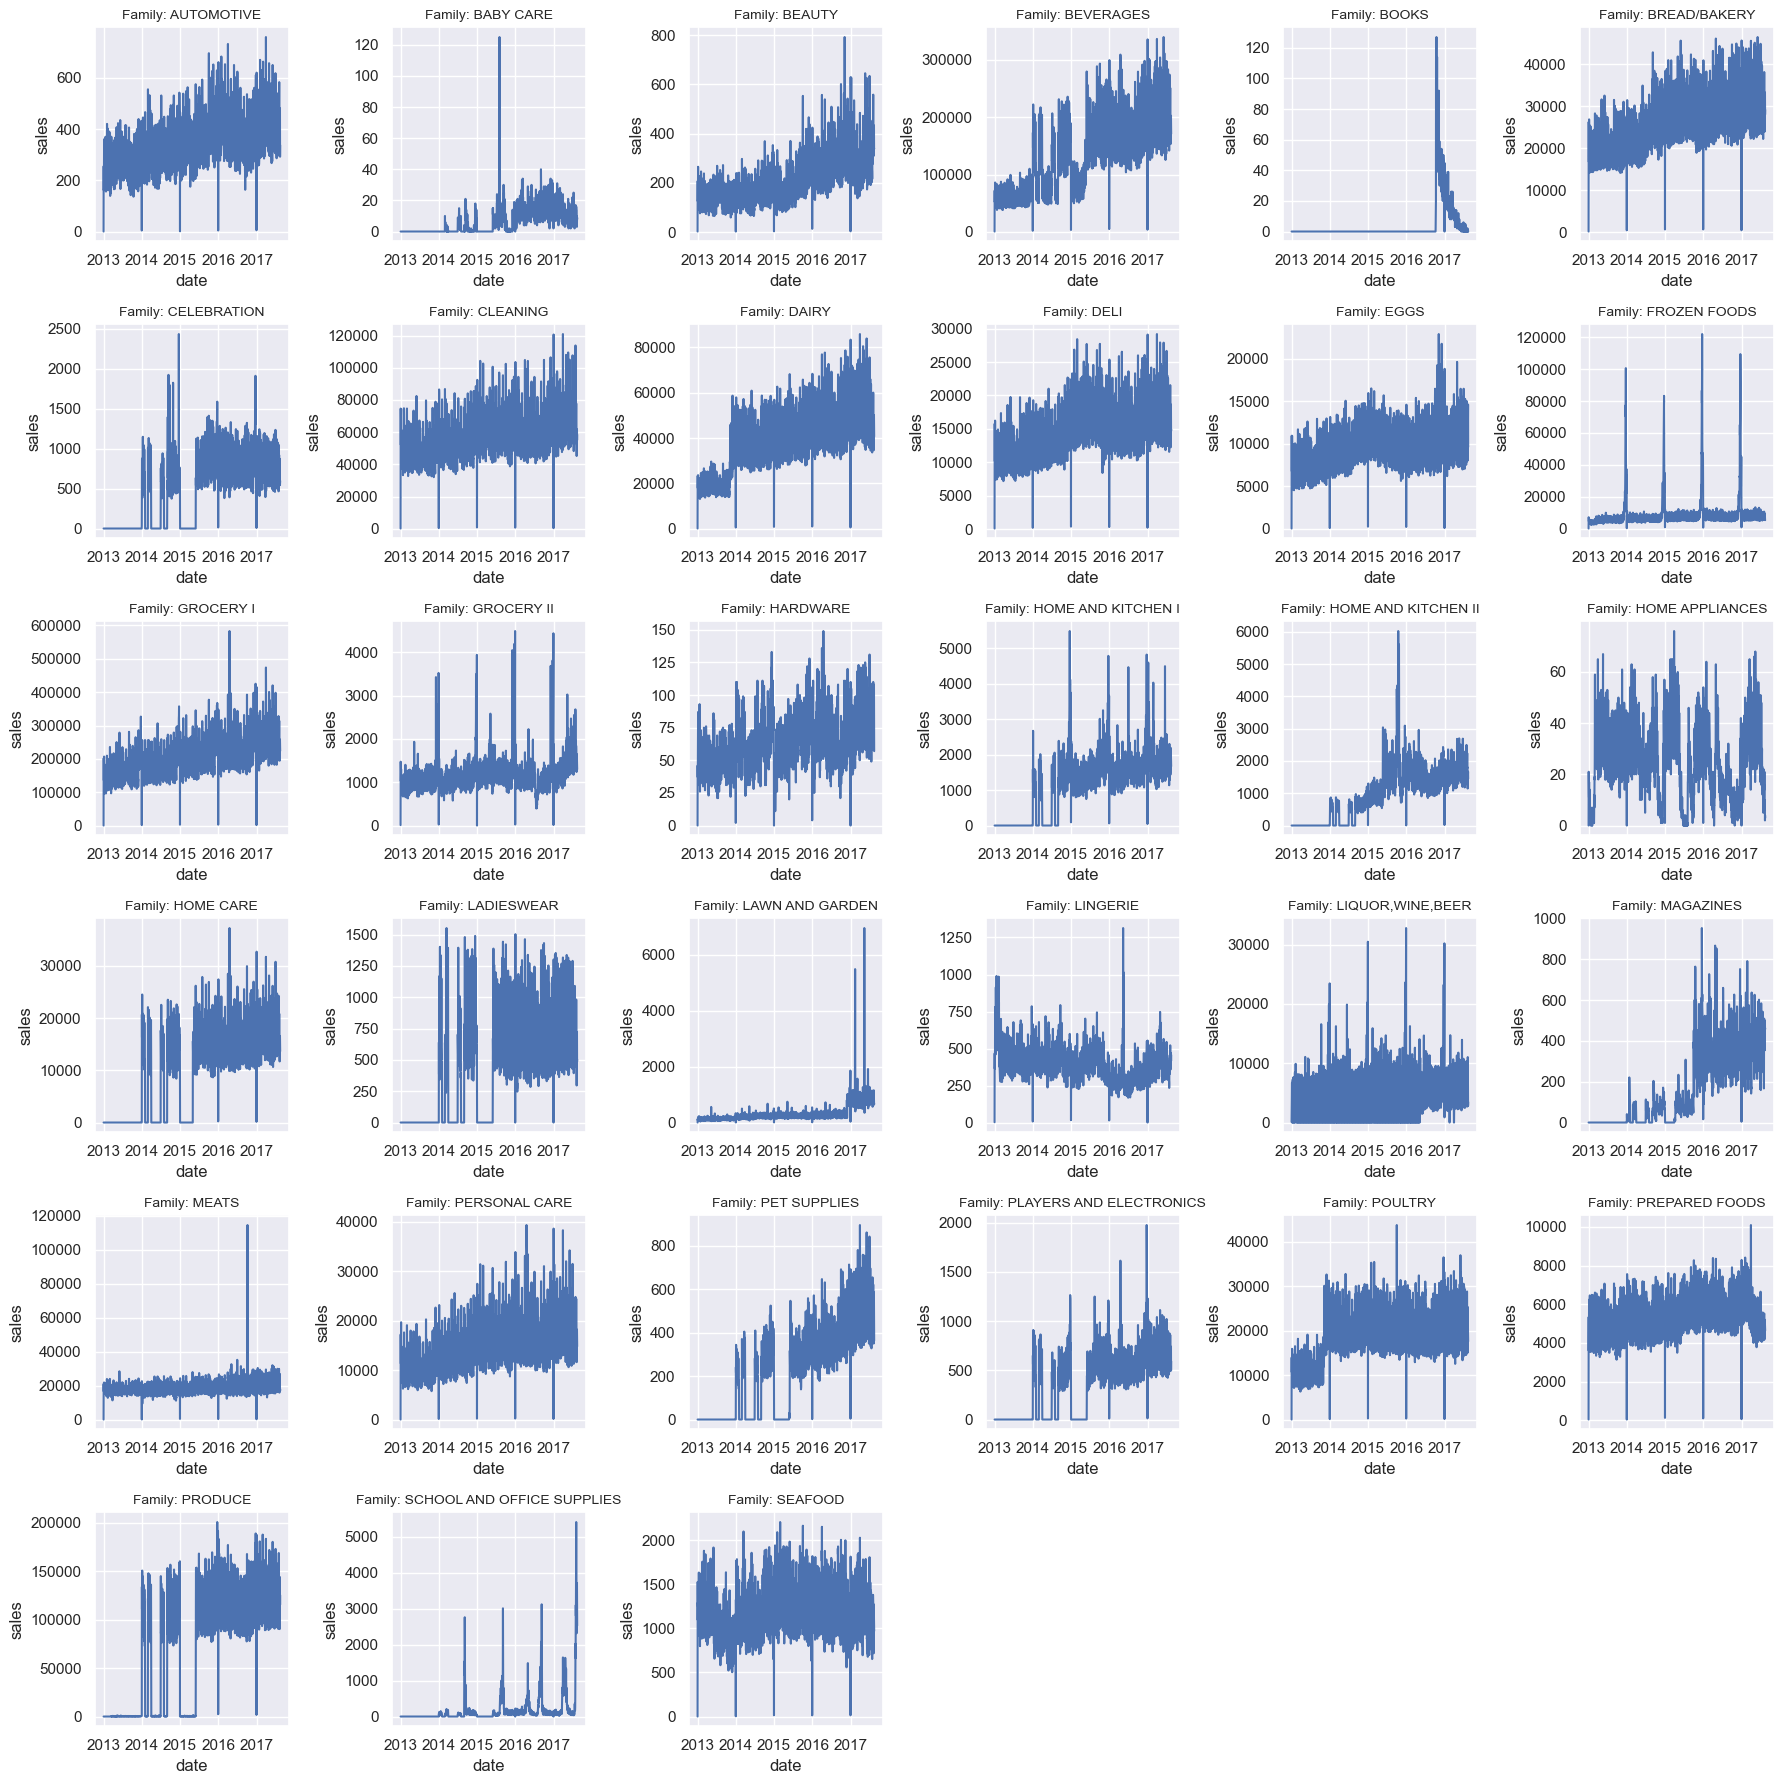

In [40]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.lineplot(ax=axes[j], data=temp_filter, x='date', y='sales')
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

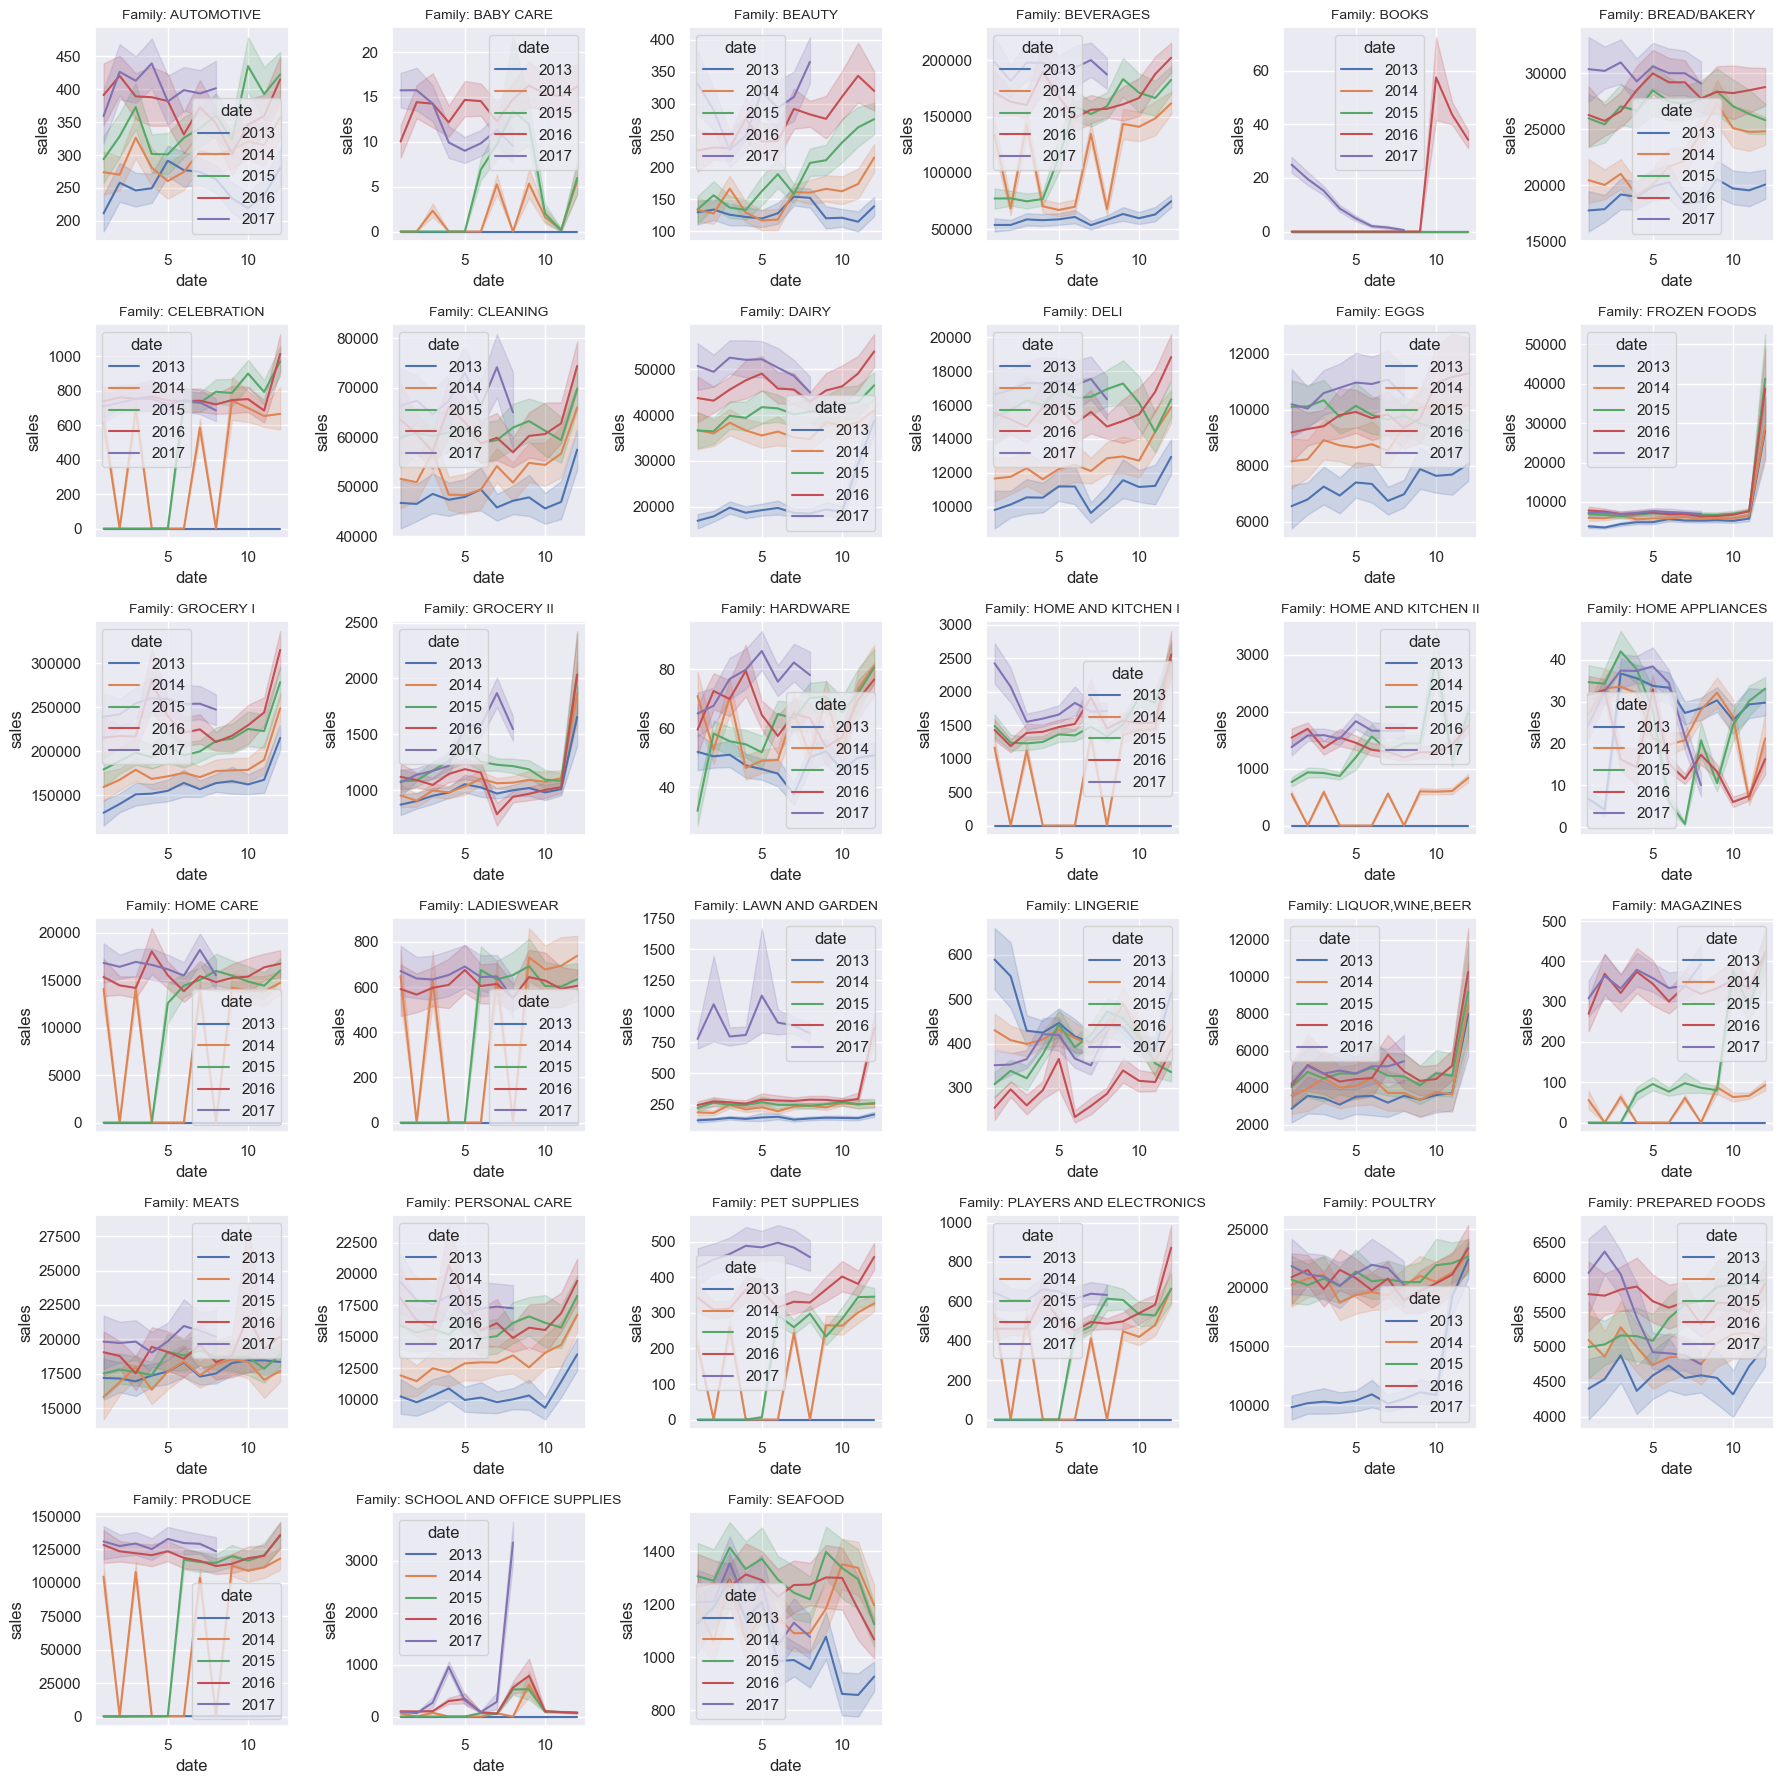

In [41]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Line plot
    (sns.lineplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.month, 
              y = 'sales', 
              hue = temp_filter['date'].dt.strftime('%Y'),
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

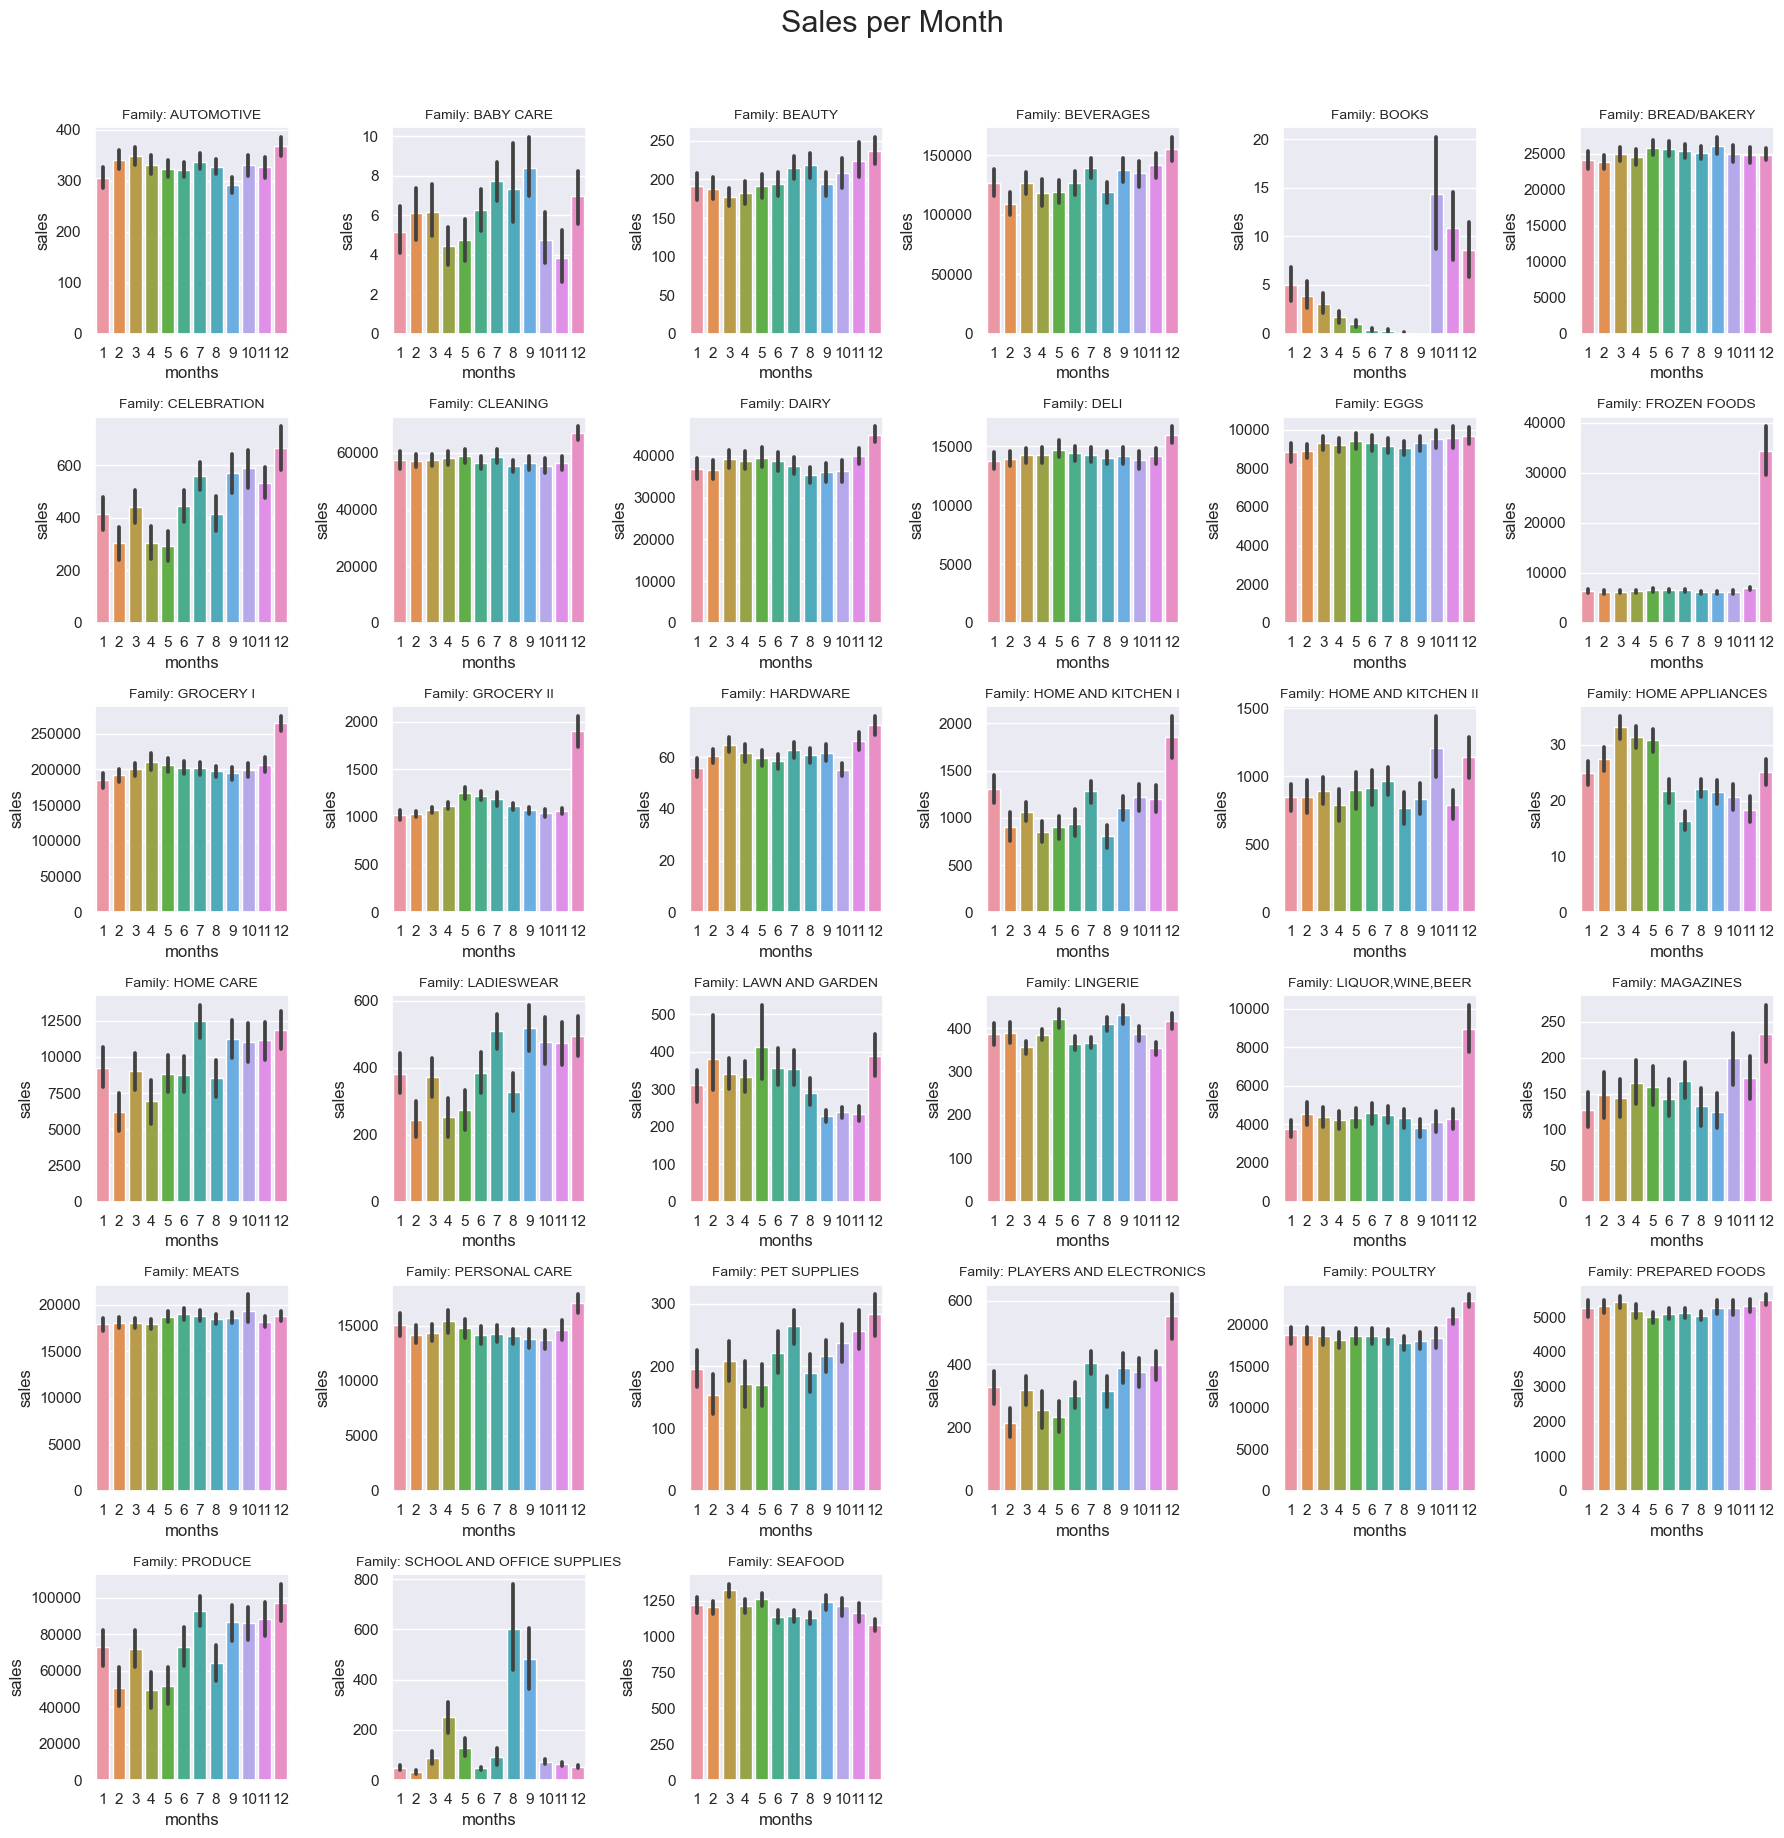

In [42]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

fig.suptitle("Sales per Month", fontsize = 22, y = 1.02)

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # bar plot
    (sns.barplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.month, 
              y = 'sales', 
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    axes[j].set_xlabel('months')
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

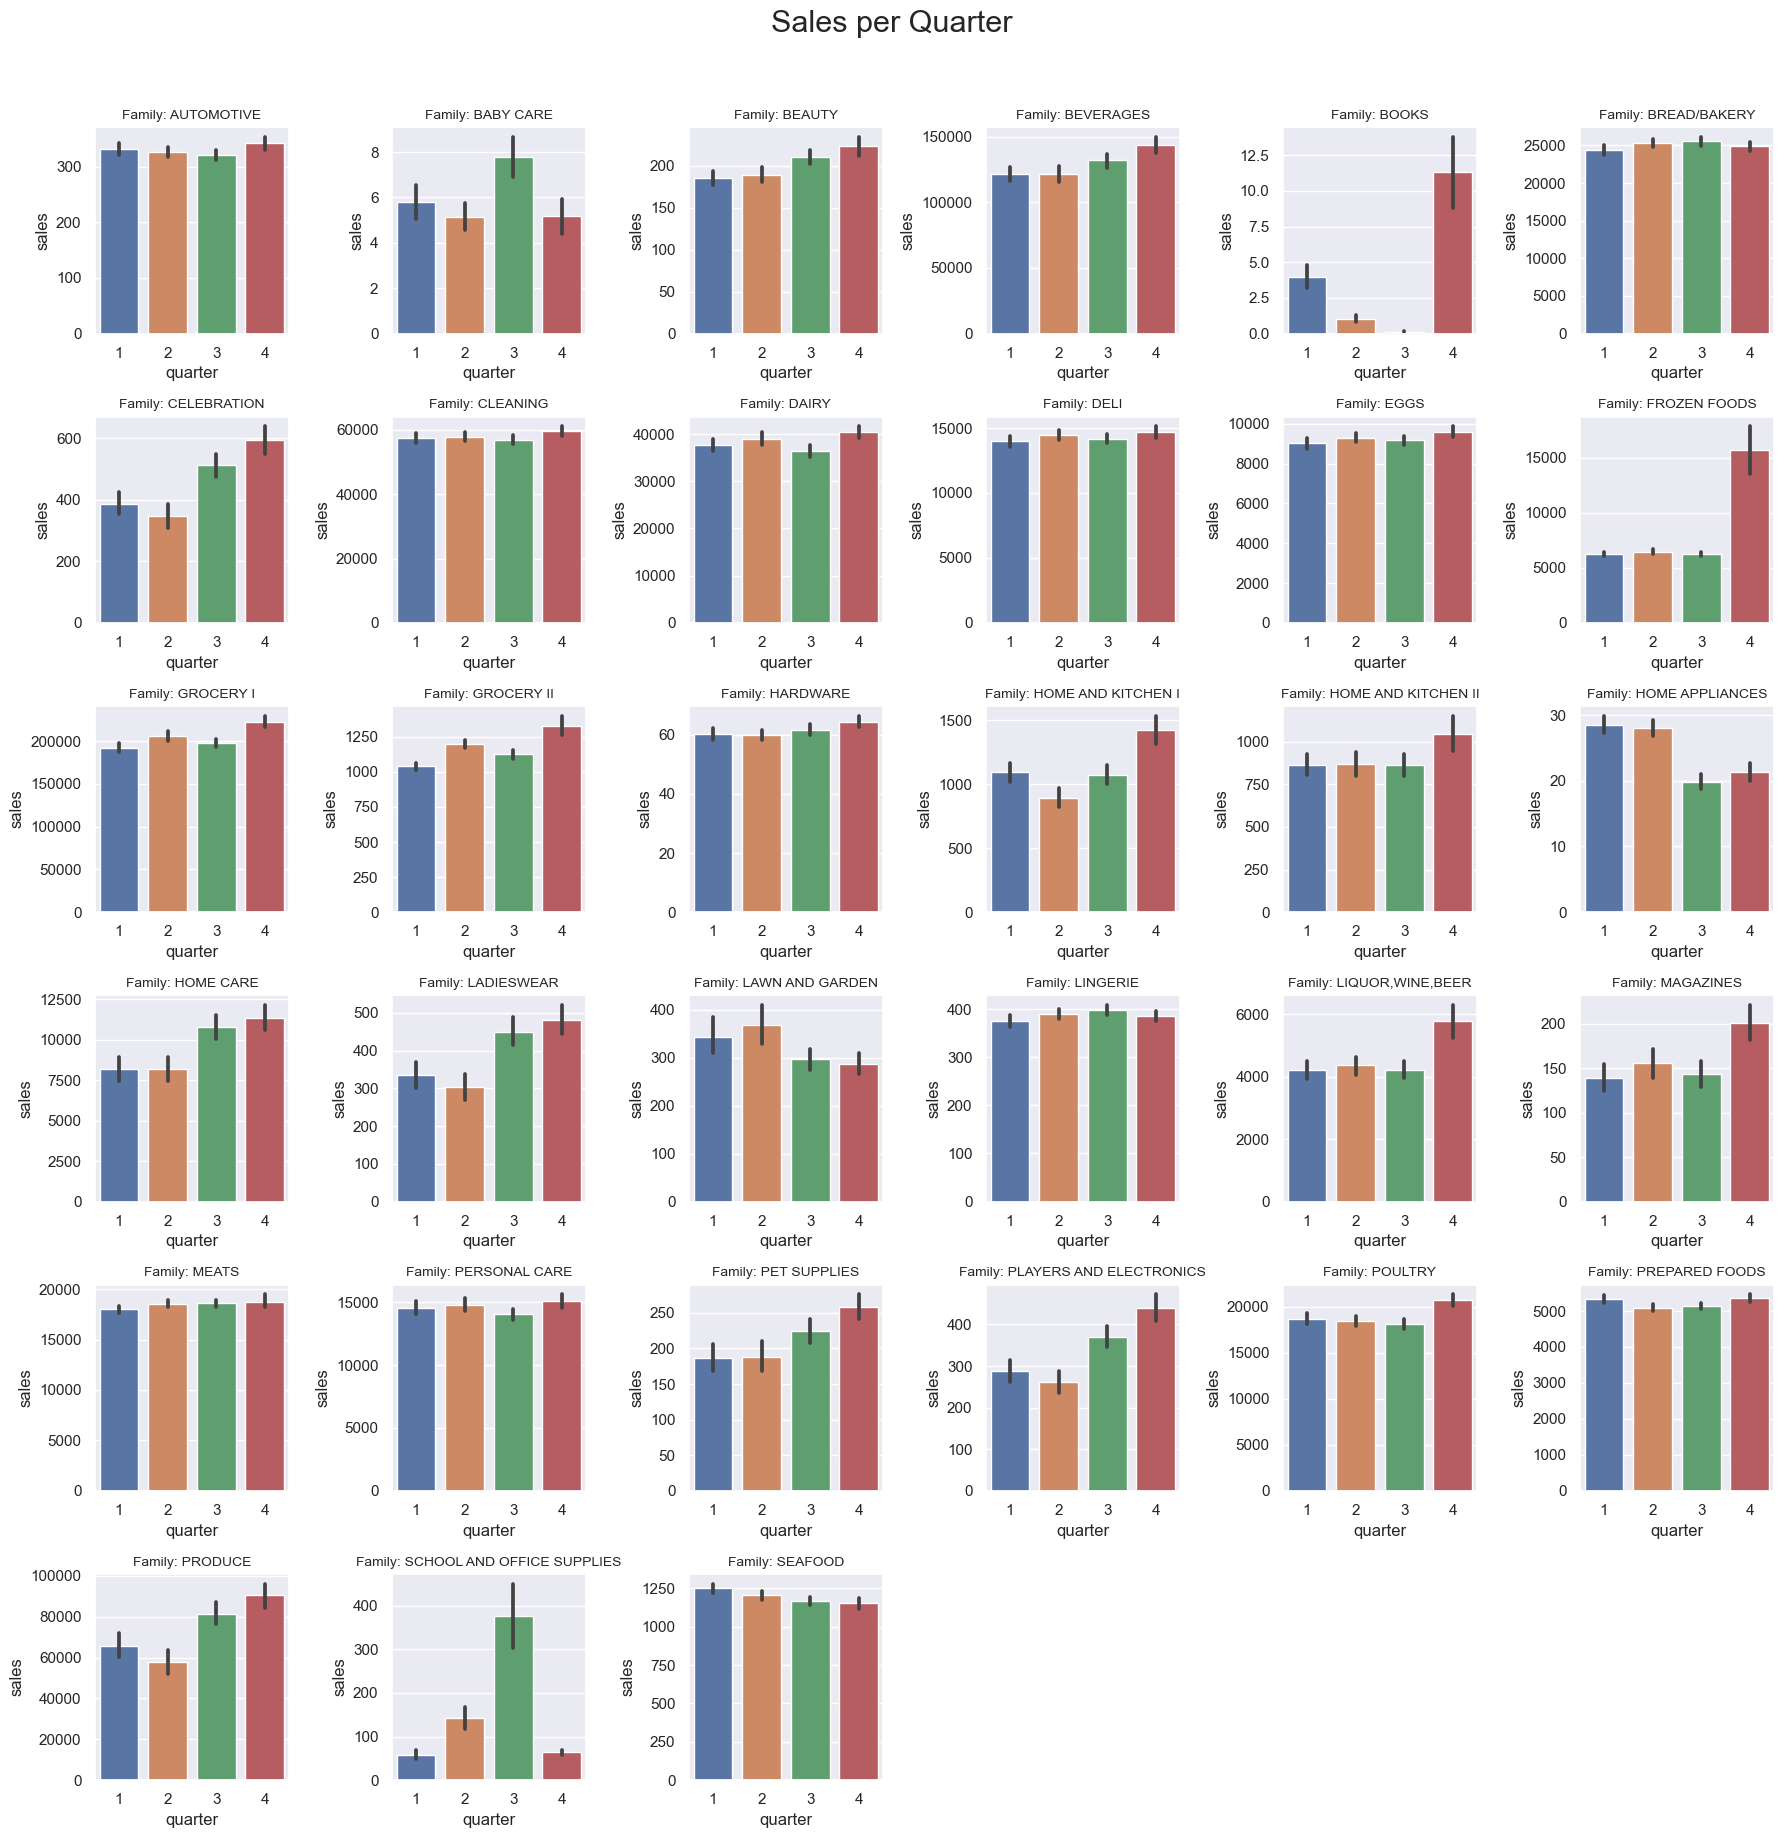

In [43]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Creation of the subplot based on the amount of product families available
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0
fig.suptitle("Sales per Quarter", fontsize = 22, y = 1.02)

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Line plot
    (sns.barplot(ax=axes[j], data = temp_filter, 
              x = temp_filter['date'].dt.quarter, 
              y = 'sales', 
              ))
    axes[j].set_title(f"Family: {i}", fontsize=10)
    axes[j].set_xlabel('quarter')
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

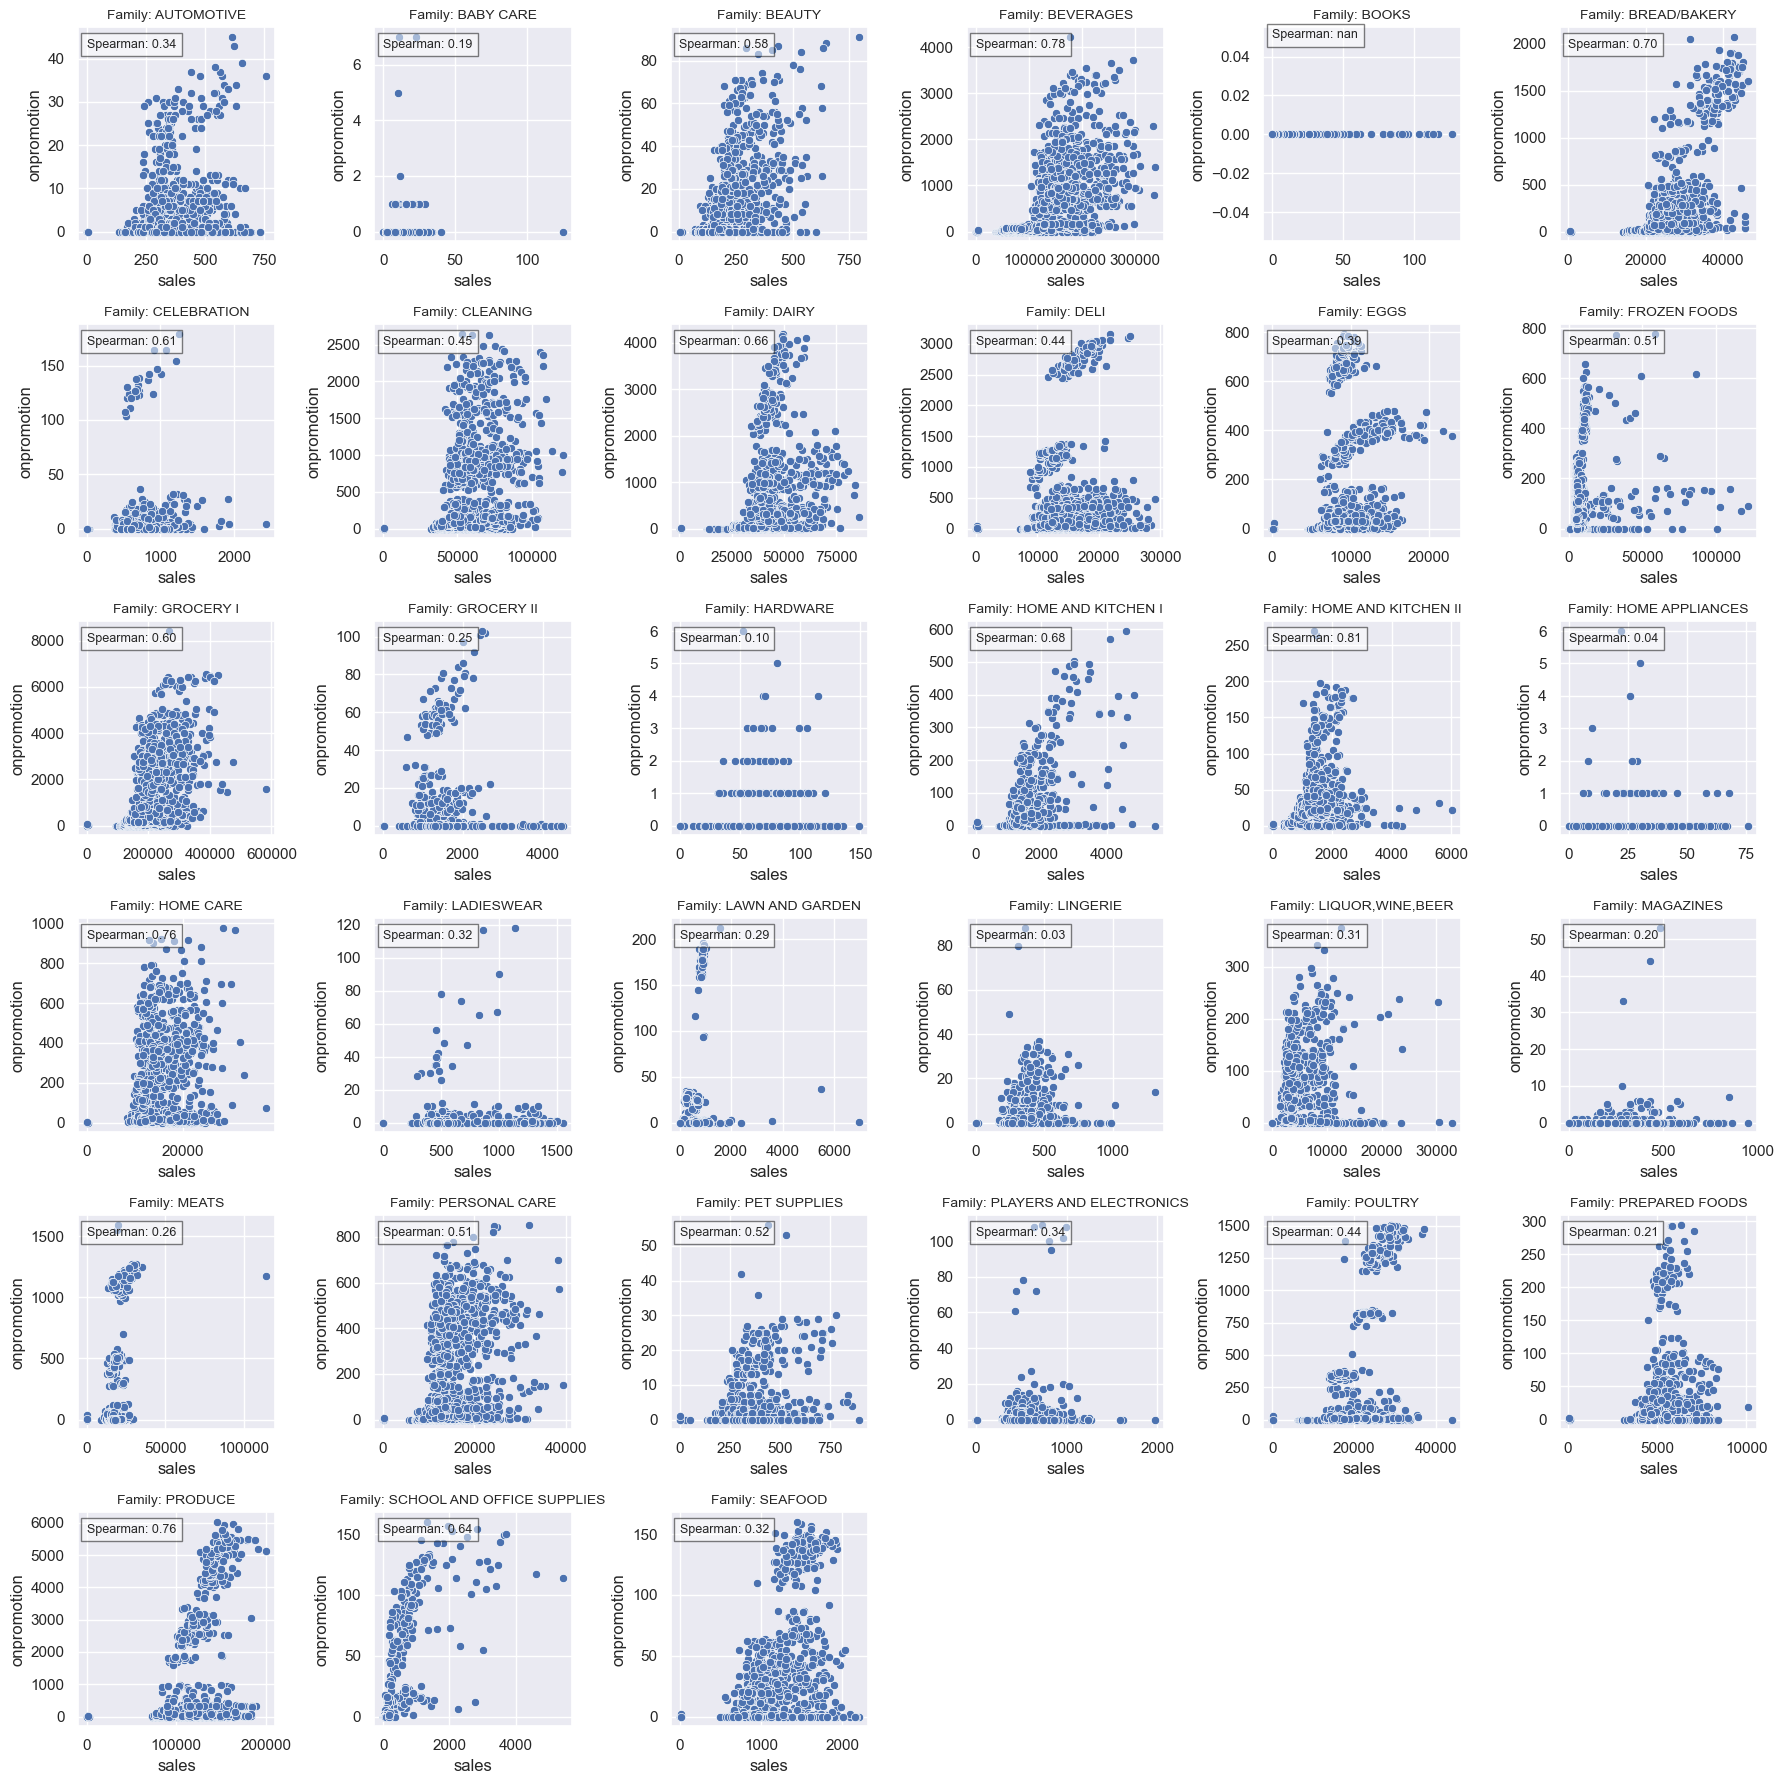

In [44]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten the 2D array into 1D
j = 0

for i in prd_sales_df['family'].unique():
    if j >= len(axes):
        break  # Avoid index error if more than 36 families

    temp_filter = prd_sales_df[prd_sales_df['family'] == i].copy()

    # Scatter plot
    sns.scatterplot(ax=axes[j], data=temp_filter, x='sales', y='onpromotion')

    # Spearman correlation
    spearman_correlation = temp_filter['sales'].corr(temp_filter['onpromotion'], method='spearman')
    textstr = f"Spearman: {spearman_correlation:.2f}"

    # Add correlation text
    x_pos = temp_filter['sales'].min() * 0.7
    y_min, y_max = axes[j].get_ylim()
    y_pos = y_max * 0.9

    axes[j].text(
        x=x_pos,
        y=y_pos,
        s=textstr,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    axes[j].set_title(f"Family: {i}", fontsize=10)
    j += 1

# Hide any unused subplots
for k in range(j, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [45]:
#### Creating a table for product performance comparison
### The dataset has a standard of showing every family product per day, even if the product was not sold at the time
### So we get the first sale date and drop everything before that so we have the accurate sales per day
### we also create some sales analysis to evaluate the family performance
mask = prd_sales_df['sales'] != 0
first_sale_date = prd_sales_df.where(mask).groupby('family')['date'].transform('min')
filtered_prd_sl_df = prd_sales_df[prd_sales_df['date'] >= first_sale_date]
prd_rlst = filtered_prd_sl_df.groupby('family', as_index= False).agg({'sales':['mean','sum','median'],'onpromotion':['mean','sum','median'], 'date':['min','count']})
prd_rlst.columns = ['_'.join(i) for i in prd_rlst.columns]
prd_rlst.rename({'family_':'family'},axis = 1, inplace = True)

In [46]:
prd_rlst['sls_per_day'] = prd_rlst['sales_sum'] / prd_rlst['date_count']
prd_rlst['promo_per_day'] = prd_rlst['onpromotion_sum'] / prd_rlst['date_count']

In [47]:
fig = px.scatter(prd_rlst[['family','sls_per_day','promo_per_day']],
                 x = 'sls_per_day',
                 y = 'promo_per_day',
                 hover_name='family',
                 labels=dict(promo_per_day='Promotions per day',sls_per_day='Sales per day'),
                 text = 'family')
fig.update_traces(textposition='top center')
fig.update_layout(
    title={
        'text': 'On Promotion per day x Sales per day scatterplot',
        'x': 0.5,  # Center the title (0 = left, 0.5 = center, 1 = right)
        'xanchor': 'center',
        'font': {
            'size': 20,
            'color': 'black',
            'family': 'Arial'
        }
    }
)
fig.show()

In [48]:
#### Get quarterly sales to find patterns and group the products using K-Means. 
# This way we can try to find patterns between the products
# Important: We normalize the data because we only want the seasonality effects per product
prd_sales_df2 = prd_sales_df.copy()
prd_sales_df2['quarter'] = prd_sales_df2['date'].dt.quarter
prd_sales_df3 = prd_sales_df2.pivot_table(index = 'family',columns = 'quarter',values = 'sales', aggfunc='sum').round(2).reset_index()
prd_sales_df3['total'] = prd_sales_df3.loc[0:,1:].sum(axis = 1).round(2)
for column in prd_sales_df3.loc[0:,1:4].columns:
    prd_sales_df3[column] = prd_sales_df3[column] / prd_sales_df3['total']
prd_sales_df3.drop('total', axis = 1, inplace = True)

In [50]:
df_prd_norm = prd_sales_df3.set_index('family').copy()

#### Applying KMeans
First we run an elbow analysis to find a good number of clusters
Then we fit and evaluate the balance and result of the groups

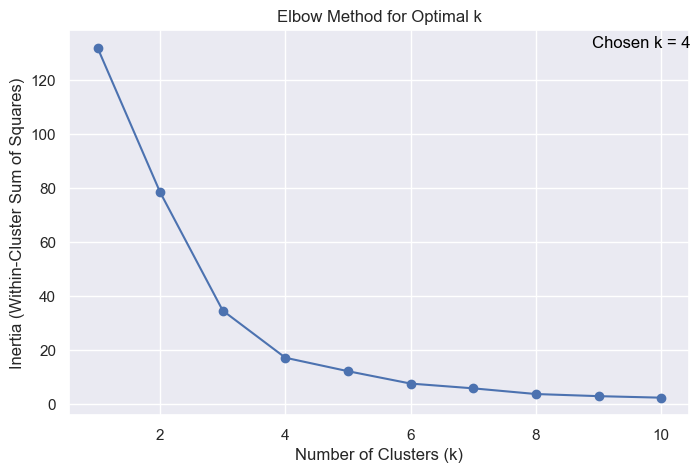

In [51]:
# Scale (just to ensure consistency)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_prd_norm)

# Calculate inertia for k = 1 to 10
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
### Adding the k selected based on the elbow analysis
plt.text(
    x = 8.9,
    y = max(inertias),
    s = "Chosen k = 4",
    fontsize = 12,
    color = 'black'
)
plt.show()

In [52]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_prd_norm)
kmeans = KMeans(n_clusters=4, random_state = 265)
clusters = kmeans.fit_predict(scaled_data)
df_prd_norm['cluster'] = clusters

#### Running some evaluation scores for the KMeans clustering

In [53]:
score = silhouette_score(scaled_data, kmeans.labels_)
print("Measures how similar each point is to its own cluster vs. others. Values range from -1 to 1.\n"
       f"Silhouette Score (k=4): {score:.3f} \n"
      "~1 = better-defined clusters / ~0 -> overlapping clusters / < 0 -> likely incorrect clustering")


Measures how similar each point is to its own cluster vs. others. Values range from -1 to 1.
Silhouette Score (k=4): 0.495 
~1 = better-defined clusters / ~0 -> overlapping clusters / < 0 -> likely incorrect clustering


In [54]:
ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)
print("Ratio of between-cluster dispersion to within-cluster dispersion.\n"
      f"Calinski-Harabasz Score (k=4): {ch_score:.2f}\n"
      "Higher = better clusters (more separated and tight)")

Ratio of between-cluster dispersion to within-cluster dispersion.
Calinski-Harabasz Score (k=4): 64.71
Higher = better clusters (more separated and tight)


In [55]:
db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
print("Measures average similarity between each cluster and its most similar one. \n"
    f"Davies-Bouldin Score (k=4): {db_score:.3f} \n"
    "Lower = better clusters")

Measures average similarity between each cluster and its most similar one. 
Davies-Bouldin Score (k=4): 0.410 
Lower = better clusters


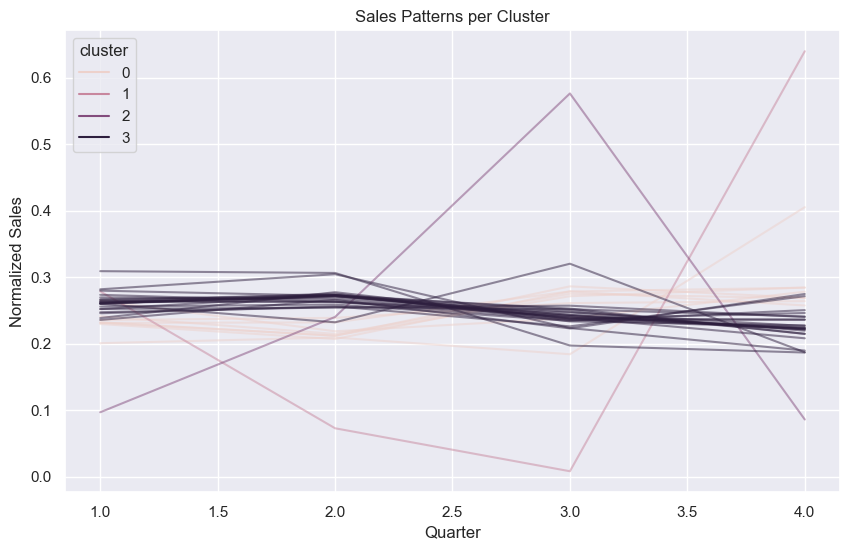

In [56]:
# Visualization: Clustered patterns
df_melted = df_prd_norm.reset_index().melt(id_vars=['family', 'cluster'], var_name='quarter', value_name='normalized_sales')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='quarter', y='normalized_sales', hue='cluster', estimator=None, units='family', alpha=0.5)
plt.title("Sales Patterns per Cluster")
plt.ylabel("Normalized Sales")
plt.xlabel("Quarter")
plt.show()

#### We can also run a PCA to see the cluster split

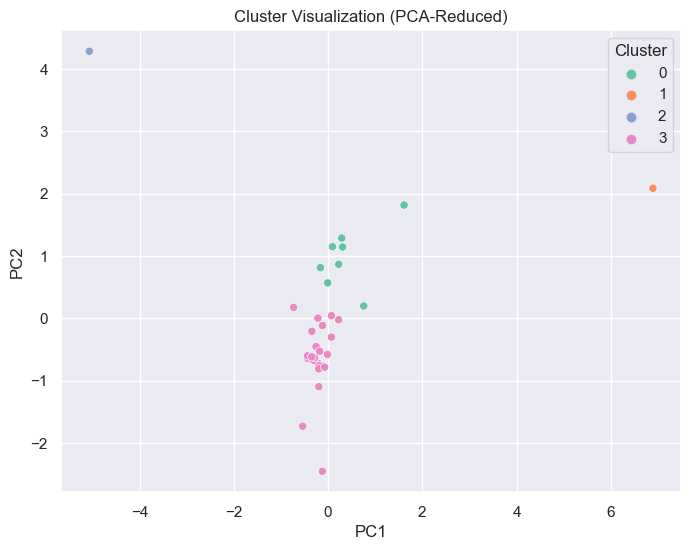

In [57]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=kmeans.labels_, palette='Set2')
plt.title("Cluster Visualization (PCA-Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#### We can use the product clustering later as a feature enginner and evaluate the feature importance
The PCA shows that there are 2 main groups that the products are mainly splits, and the cluster 1 and 2
are outliers

The cluster 1 is BOOKS, which had the sales mostly concentrated in the 4th quarter

The cluster 2 is School and Office supplies, which is probably correlated with school start

In [61]:
df_prd_norm.query('cluster.isin([1,2])')

quarter                            1         2         3         4  cluster
family                                                                     
BOOKS                       0.278813  0.073004  0.008388  0.639795        1
SCHOOL AND OFFICE SUPPLIES  0.097087  0.240364  0.576345  0.086204        2

#### Evaluating Sales and Holidays relationship
Here we are looking for the impact of holidays in the sales per region

There are more than one approach to model the holidays impact in sales

For now we will proceed with the assumption that each holiday impacts the sales similarly

Another approach would be to create dummies based on each holiday and evaluate the feature imporance;
Which we can also explore later

In [ ]:
#### First lets evaluate the relationship of total sales and national holidays
#### We will create a binary column to show it is an national holiday

### Adapt the dataframe
national_holidays = holidays_df4[holidays_df4['locale'] == 'National'][['date','locale_name']].copy()
national_holidays['date'] = pd.to_datetime(national_holidays['date'])

### Merge sales and national holiday dataframe
ttl_sls_nat_hlds = total_sales.iloc[0:,0:3].merge(national_holidays, how = 'left', on = 'date')

### Rename the column and create the binary values
test = pd.get_dummies('')
ttl_sls_nat_hlds.rename({'locale_name':'nat_holiday'}, axis = 1, inplace = True)

ttl_sls_nat_hlds

date          sales  onpromotion locale_name
0    2013-01-01    2511.618999            0     Ecuador
1    2013-01-02  496092.417944            0         NaN
2    2013-01-03  361461.231124            0         NaN
3    2013-01-04  354459.677093            0         NaN
4    2013-01-05  477350.121229            0     Ecuador
...         ...            ...          ...         ...
1679 2017-08-11  826373.722022        14179     Ecuador
1680 2017-08-12  792630.535079         8312         NaN
1681 2017-08-13  865639.677471         9283         NaN
1682 2017-08-14  760922.406081         8043         NaN
1683 2017-08-15  762661.935939        10605         NaN

[1684 rows x 4 columns]

In [65]:
total_sales.head(1)

date        sales  onpromotion  dif_sales
0 2013-01-01  2511.618999            0        0.0

#### Evaluating Sales and Oil price relationship
The idea is to find how the changes in the oil price impact the sales of the store.
To do that, we need to evaluate multiple stock indicators, such as correlation with t-1; t-2;
Last 7 days variation; and so on

#### Creating the final file

In [ ]:
transactions_df.head(1)

date  store_nbr  transactions
0  2013-01-01         25           770

In [ ]:
stores_df.head(1)

store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13

In [ ]:
train_df.tail(1)

id        date  store_nbr   family  sales  onpromotion
3000887  3000887  2017-08-15          9  SEAFOOD   16.0            0

In [26]:
test_df.head(1)

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0

In [27]:
store_prod = train_df[['store_nbr','family']].drop_duplicates().copy()
store_prod = store_prod.merge(stores_df, how = 'left', on = 'store_nbr')

In [28]:
store_prod

store_nbr                      family   city      state type  cluster
0             1                  AUTOMOTIVE  Quito  Pichincha    D       13
1             1                   BABY CARE  Quito  Pichincha    D       13
2             1                      BEAUTY  Quito  Pichincha    D       13
3             1                   BEVERAGES  Quito  Pichincha    D       13
4             1                       BOOKS  Quito  Pichincha    D       13
...         ...                         ...    ...        ...  ...      ...
1777          9                     POULTRY  Quito  Pichincha    B        6
1778          9              PREPARED FOODS  Quito  Pichincha    B        6
1779          9                     PRODUCE  Quito  Pichincha    B        6
1780          9  SCHOOL AND OFFICE SUPPLIES  Quito  Pichincha    B        6
1781          9                     SEAFOOD  Quito  Pichincha    B        6

[1782 rows x 6 columns]